In [1]:
import torch
import boda

import sys
sys.path.insert(0, "/home1/smaruj/AkitaMini-pytorch")  # Add the directory where "ledidi" is located
from model import SeqNN

In [2]:
from akita_helper import plot_map, from_upper_triu

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [4]:
model = SeqNN()

# Load the saved model weights
model.load_state_dict(torch.load('/home1/smaruj/AkitaMini-pytorch/best_model.pth'))

/tmp/SLURM_225516/ipykernel_645175/2425661507.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home1/smaruj/AkitaMini-pytorch/best_mode

<All keys matched successfully>

In [5]:
model = model.to(device)

In [6]:
device = next(model.parameters()).device
print(device)

cuda:0


In [7]:
# Set the model to evaluation mode (important for inference)
model.eval()

SeqNN(
  (stochastic_reverse_complement): StochasticReverseComplement()
  (stochastic_shift): StochasticShift()
  (re_lu): ReLU()
  (conv_block_1): ConvBlock(
    (conv): Conv1d(4, 96, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
    (batch_norm): BatchNorm1d(96, eps=0.001, momentum=0.0735, affine=True, track_running_stats=True)
    (pool): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_tower): ConvTower(
    (conv_tower): Sequential(
      (0): ReLU()
      (1): Conv1d(96, 96, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (2): BatchNorm1d(96, eps=0.001, momentum=0.0735, affine=True, track_running_stats=True)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): ReLU()
      (5): Conv1d(96, 96, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (6): BatchNorm1d(96, eps=0.001, momentum=0.0735, affine=True, track_running_stats=True)
      (7): MaxPool1d(kernel_size

In [8]:
from torchinfo import summary

summary(model, input_size=(2, 4, 32768), col_names=["output_size", "num_params"])

Layer (type:depth-idx)                   Output Shape              Param #
SeqNN                                    [2, 1, 1953]              --
├─StochasticReverseComplement: 1-1       [2, 4, 32768]             --
├─StochasticShift: 1-2                   [2, 4, 32768]             --
├─ReLU: 1-3                              [2, 4, 32768]             --
├─ConvBlock: 1-4                         [2, 96, 4096]             --
│    └─Conv1d: 2-1                       [2, 96, 32768]            4,224
│    └─BatchNorm1d: 2-2                  [2, 96, 32768]            192
│    └─MaxPool1d: 2-3                    [2, 96, 4096]             --
├─ConvTower: 1-5                         [2, 96, 64]               --
│    └─Sequential: 2-4                   [2, 96, 64]               --
│    │    └─ReLU: 3-1                    [2, 96, 4096]             --
│    │    └─Conv1d: 3-2                  [2, 96, 4096]             46,080
│    │    └─BatchNorm1d: 3-3             [2, 96, 4096]             192
│    │

In [9]:
# Load the test data
test_data = torch.load('/home1/smaruj/AkitaMini-pytorch/test_data.pt')

# Assume test_data is a tuple of (X, y)
X_test, y_test = test_data

/tmp/SLURM_225516/ipykernel_645175/413687493.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load('/home1/smaruj/AkitaMini-pytorch/test_data.pt')


In [10]:
num_examples = 3
X_batch = X_test[:num_examples]
y_batch = y_test[:num_examples]

In [11]:
X_batch, y_batch = X_batch.to(device), y_batch.to(device)

In [12]:
# Get predictions
with torch.no_grad():
    predictions = model(X_batch)

In [13]:
import numpy as np

# Function to get the indices of the upper triangular part for a given matrix size
def get_upper_triu_indices(dim, num_diags=2):
    return np.triu_indices(dim, k=num_diags)

# The matrix size you are working with
dim = 64
# The starting and ending indices for the chunk (0:21, 21:38)
start_row, end_row = 0, 20
start_col, end_col = 20, 36

# Get the full upper triangular indices for the 64x64 matrix
full_indices = get_upper_triu_indices(dim)

# Now create a mask to extract the relevant slice of the matrix
mask = ((full_indices[0] >= start_row) & (full_indices[0] < end_row) &
        (full_indices[1] >= start_col) & (full_indices[1] < end_col))

# Extract the corresponding indices from the full 64x64 vector
sub_indices_in_full_vector = np.where(mask)[0]



In [14]:
def indices_to_slices_fixed(indices):
    slices = []
    start = indices[0]
    
    for i in range(1, len(indices)):
        if indices[i] != indices[i-1] + 1:  # New contiguous block detected
            slices.append(slice(start, indices[i-1] + 1))
            start = indices[i]
    
    # Append the last slice
    slices.append(slice(start, indices[-1] + 1))
    
    # Compute the max slice length
    max_length = max(s.stop - s.start for s in slices)

    # Expand shorter slices to match max_length
    slices_fixed = []
    for s in slices:
        length = s.stop - s.start
        if length < max_length:
            new_stop = s.start + max_length  # Expand
            slices_fixed.append(slice(s.start, new_stop))
        else:
            slices_fixed.append(s)
    
    return slices_fixed


In [15]:
slices = indices_to_slices_fixed(sub_indices_in_full_vector)

In [16]:
slices

[slice(18, 34, None),
 slice(79, 95, None),
 slice(139, 155, None),
 slice(198, 214, None),
 slice(256, 272, None),
 slice(313, 329, None),
 slice(369, 385, None),
 slice(424, 440, None),
 slice(478, 494, None),
 slice(531, 547, None),
 slice(583, 599, None),
 slice(634, 650, None),
 slice(684, 700, None),
 slice(733, 749, None),
 slice(781, 797, None),
 slice(828, 844, None),
 slice(874, 890, None),
 slice(919, 935, None),
 slice(963, 979, None),
 slice(1007, 1023, None)]

# CODA

In [ ]:
# Fast SeqProp

In [17]:
# logits = torch.randn(
# 1, 4, 336
# )

logits = torch.randn(
10, 4, 336
)

left_flank = X_batch[1,:, :10328].unsqueeze(0).repeat(10, 1, 1)

right_flank = X_batch[1,:, :-10664].unsqueeze(0).repeat(10, 1, 1)

In [18]:
left_flank.shape, right_flank.shape

(torch.Size([10, 4, 10328]), torch.Size([10, 4, 22104]))

In [ ]:
10328 + 22104 + 336

In [19]:
params = boda.generator.BasicParameters(
    data=logits, left_flank=left_flank, right_flank=right_flank
)
params.cuda()

BasicParameters()

In [20]:
# energy = boda.generator.MinGapEnergy(model, target_feature=21, target_alpha=-1, a_min=-2., a_max=6.)
# energy = boda.generator.MinGapEnergy(model, target_feature=slice(96,980), target_alpha=-1, a_min=-2., a_max=6.)
energy = boda.generator.MinGapEnergy(model, target_feature=slices, target_alpha=-1, a_min=-2., a_max=6.)

#Higher or Lower?:
# - If you want the target feature to be higher in the energy calculation (i.e., the energy should be lower when the target feature is higher), 
# then you’ll use a positive target_alpha.
# - If you want the target feature to be lower (i.e., the energy should be lower when the target feature is lower), 
# then you’ll use a negative target_alpha.

In [21]:
SA = boda.generator.SimulatedAnnealing(params, energy, n_positions=3, gamma=0.501)

In [23]:
samples = SA.collect_samples(n_steps=20000, n_burnin=0)

for k in samples['samples'].keys():
    print(k)
    if samples['samples'][k] is not None:
        print(f"\t{samples['samples'][k].shape}")
    else:
        print("\tNone")

collect samples


step0 20000


100%|██████████| 20000/20000 [07:42<00:00, 43.22it/s]


states
	torch.Size([20000, 10, 4, 336])
energies
	torch.Size([20000, 10, 1])
acceptances
	torch.Size([20000, 10, 1])


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [25]:
A_col = (12, 128, 64)
C_col = (56, 83, 164)
G_col = (251, 177, 22)
T_col = (237, 31, 36)
nt_col = np.array([A_col, C_col, G_col, T_col])

8


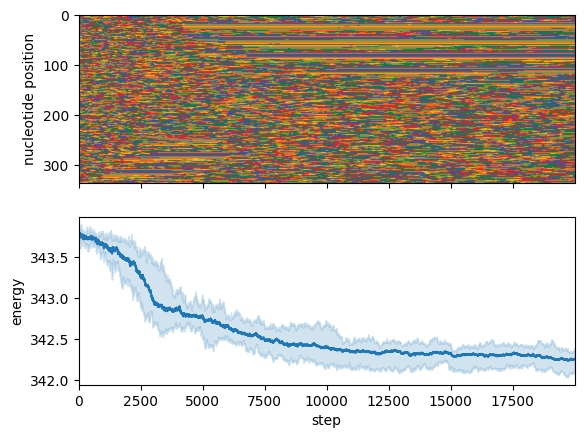

In [27]:
fig, ax = plt.subplots(2,1,sharex=True)

seq_idx = np.random.choice(np.arange(10))
print(seq_idx)
ax[0].imshow(
    np.concatenate(
        [
            nt_col[samples['samples']['states'][:,seq_idx,:,:].max(dim=1).indices]/255.,
            #F.softmax(torch.tensor(FSP.param_hist[:,seq_idx,:,:]),dim=1).max(dim=1).values[:,:,np.newaxis]
        ],
        axis=-1
    ).transpose(1,0,2)
    
)
ax[0].set_aspect('auto')
ax[0].set_ylabel('nucleotide position')

sns.lineplot(
    data=pd.DataFrame(
    {'energy': samples['samples']['energies'].flatten(),
    'step': np.repeat(np.arange(20000), 10)}
    ), 
    x='step',
    y='energy',
    errorbar="pi",
    ax=ax[1]
)


plt.show()

In [30]:
samples = SA.generate(n_proposals=10, n_steps=20000, n_burnin=0)

for k in samples.keys():
    print(k)
    print(f"\t{samples[k].shape}")

collect samples


step0 20000


100%|██████████| 20000/20000 [07:42<00:00, 43.27it/s]


attempt 1 acceptance rate: 10/10
proposals
	torch.Size([10, 4, 336])
energies
	torch.Size([10, 1])
acceptance_rate
	torch.Size([0])


In [31]:
squeezed_proposals = samples["proposals"][0]

In [32]:
og_seq = X_batch[1,:,:].clone()

In [33]:
mod_seq = og_seq.clone()
mod_seq[:, 10328:10664] = squeezed_proposals

In [34]:
(og_seq != mod_seq).sum() // 2

tensor(264, device='cuda:0')

In [35]:
mod_seq_dim = mod_seq.unsqueeze(0)

In [36]:
with torch.no_grad():
    predictions_new = model(mod_seq_dim)

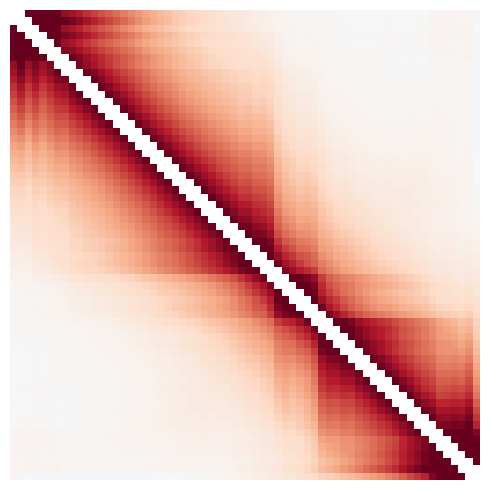

In [37]:
plot_map(from_upper_triu(predictions[1], matrix_len=64, num_diags=2), vmin=-0.6, vmax=0.6, palette="RdBu_r", width=5, height=5)

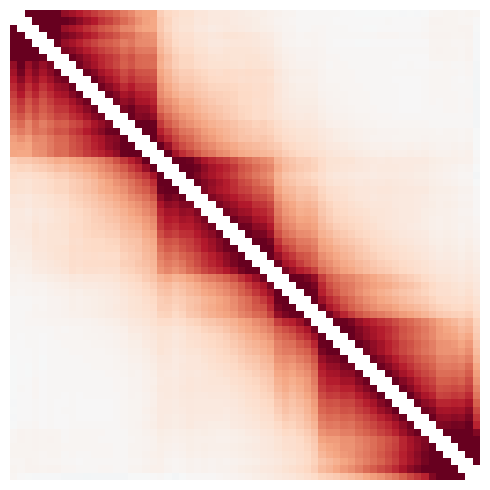

In [38]:
plot_map(from_upper_triu(predictions_new, matrix_len=64, num_diags=2), vmin=-0.6, vmax=0.6, palette="RdBu_r", width=5, height=5)

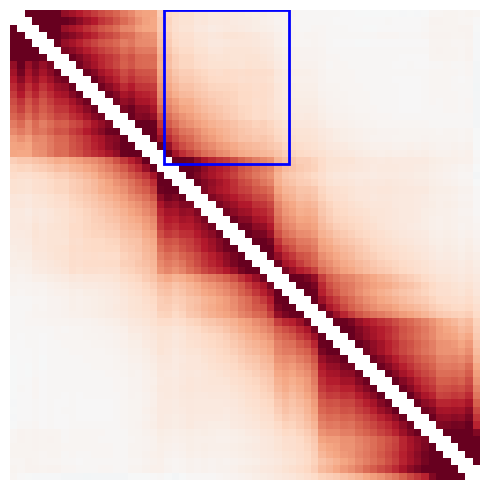

In [39]:
highlight_region = (0, 21, 21, 38)
plot_map(from_upper_triu(predictions_new, matrix_len=64, num_diags=2), highlight_region=highlight_region)

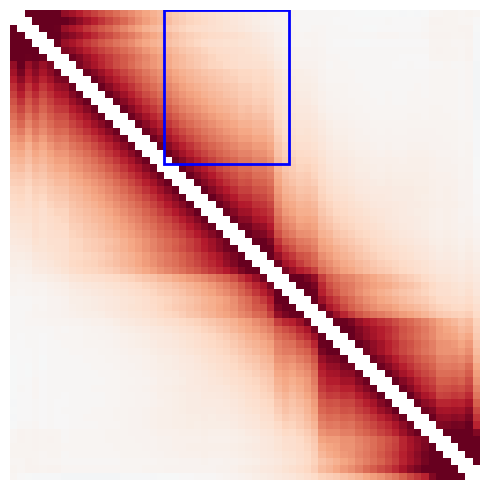

In [40]:
plot_map(from_upper_triu(predictions[1], matrix_len=64, num_diags=2), vmin=-0.6, vmax=0.6, palette="RdBu_r", width=5, height=5, highlight_region=highlight_region)